In [77]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [78]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [79]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [80]:
pip install --upgrade pandas numpy prophet

Note: you may need to restart the kernel to use updated packages.


In [81]:
pip install --upgrade pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [82]:
import pandas as pd
from prophet import Prophet

In [83]:
pd.set_option('display.width', 300)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [84]:
# Load the Medicaid Enrollment Data
df = pd.read_csv('Medicaid_data.csv', encoding = 'unicode_escape')

In [85]:
df = df[df['final_report'] == 'Y']   # Need rows that are the final report only
df = df[df['report_date'] != '09/01/2013']    # Remove the date 09/01/2013 since it was the only date before 06/01/2017
df.dropna(subset=['total_medicaid_enrollment'], inplace=True)   # removes the rows that are empty

In [86]:
# Convert 'report_date' to datetime format for time series analysis
df['report_date'] = pd.to_datetime(df['report_date'])

# Create a monthly period column from 'report_date' to aggregate data on a monthly basis
df['month'] = df['report_date'].dt.to_period('M')

In [87]:
# Aggregate data monthly including state abbreviation
monthly_data = df.groupby(['month', 'state_abbreviation']).agg(total_medicaid_enrollment=('total_medicaid_enrollment', 'sum')).reset_index()
monthly_data['ds'] = monthly_data['month'].dt.to_timestamp()
monthly_data['y'] = monthly_data['total_medicaid_enrollment']

In [88]:
# General prediction including all states
model = Prophet()
model.fit(monthly_data[['ds', 'y']])
future = model.make_future_dataframe(periods=120, freq='M')  # 10 years monthly forecast
forecast = model.predict(future)

13:34:25 - cmdstanpy - INFO - Chain [1] start processing
13:34:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Owner\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [89]:
forecast.to_csv('General_monthly_Medicaid_Enrollment_forecast.csv', index=False)

In [90]:
# Concatenate the original and forecasted dataframes
combined_df = pd.concat([df, forecast_future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]], ignore_index=True)

In [91]:
import matplotlib.pyplot as plt

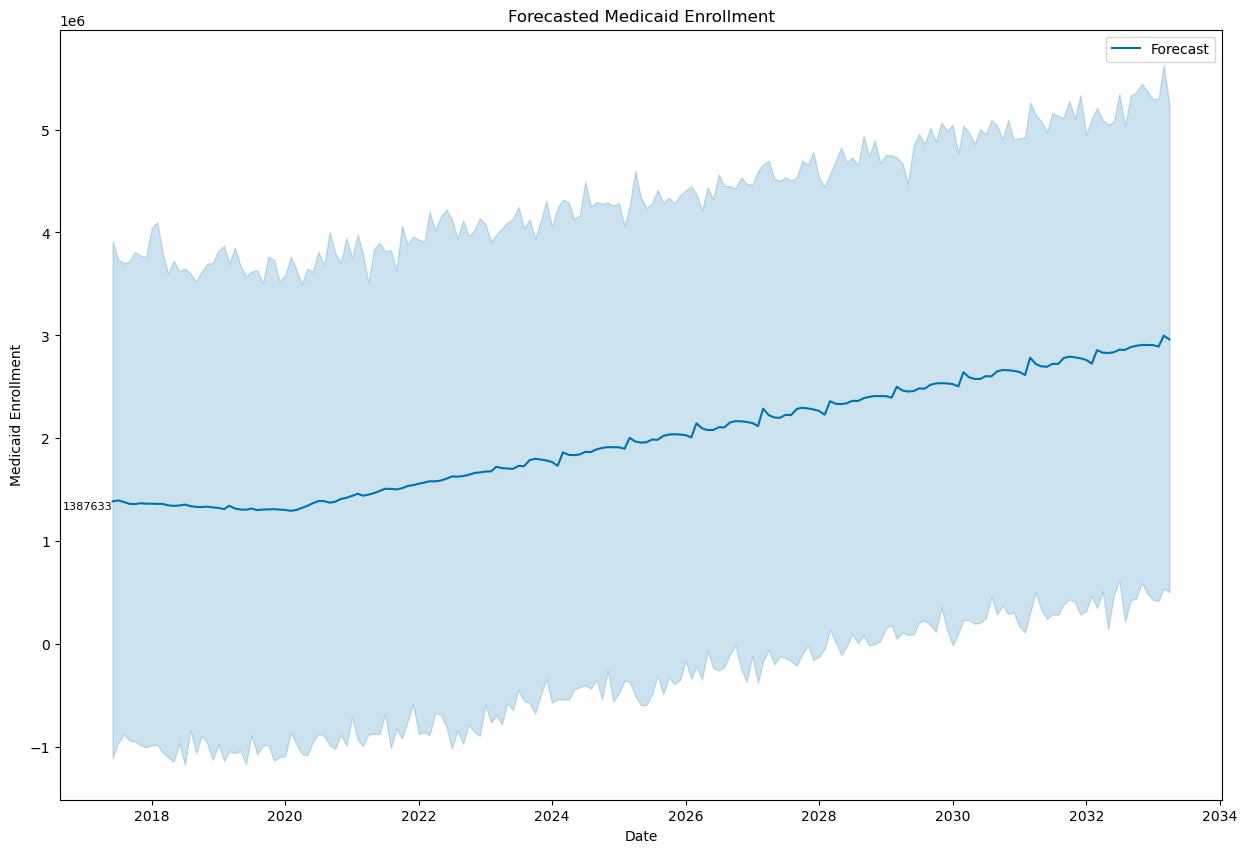

In [92]:
# Increase the figure size to give more room for labels
plt.figure(figsize=(15, 10))  # Adjust the size as needed

# Plot the forecast results
plt.plot(forecast['ds'], forecast['yhat'], '-', label='Forecast', color='#0072B2')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#0072B2', alpha=0.2)

# Calculate the direction of the prediction
prediction_direction = forecast['yhat'].diff()

# Add labels selectively to avoid clutter
# For instance, label only the first point of each year
for i, (x, y, direction) in enumerate(zip(forecast['ds'], forecast['yhat'], prediction_direction)):
    if i % 365 == 0:  # Assuming daily data; adjust the modulus for your data frequency
        # Choose alignment based on direction
        va_alignment = 'bottom' if direction >= 0 else 'top'
        # Add label with alignment
        plt.text(x, y, f"{y:.0f}", fontsize=8, ha='right', va=va_alignment)  # Adjust fontsize as needed

# Add the rest of the plot elements
plt.xlabel('Date')
plt.ylabel('Medicaid Enrollment')
plt.title('Forecasted Medicaid Enrollment')
plt.legend()

# Show the plot
plt.show()
